<h1><center>Assignment - 1</center></h1>
<h5> Collaborated with Vihari Vasikarla, Sankranthi Chinthamaneni and other non-human collaborators mentioned at the end. </h5>

# INTRODUCTION

#### Overview and Importance in Environmental Science
ClimateBench serves as a benchmarking framework leveraging machine learning models to effectively simulate intricate Earth system models. This framework enables swift exploration of climate scenarios by providing comprehensive evaluation metrics to validate these simulations. By enhancing climate research and policy-making, ClimateBench makes detailed climate projections more accessible and cost-effective, ultimately contributing to a better understanding of climate dynamics.

#### Significance of regressing aerosol and greenhouse gas emissions onto climate model temperature responses
Regressing aerosol and greenhouse gas emissions against climate model temperature responses is essential as it enables researchers to quantitatively evaluate and forecast the influence of different emission types on global temperature trends. This approach is instrumental in comprehending the precise effects of diverse pollutants on climate variability, thereby aiding the development of targeted mitigation measures and policy interventions.

# MODEL EXPLORATION

## CNN-LSTM

#### About the Model

The CNN-LSTM architecture combines Convolutional Neural Networks (CNNs) with Long Short-Term Memory (LSTM) networks, integrating their respective strengths to model spatio-temporal data effectively. CNNs are known for their ability to automatically learn hierarchical representations of data, making them effective for feature extraction from spatial data like climate variables. LSTM layers excel in modeling sequential data, making them suitable for capturing temporal dependencies in climate data. CNNs are robust to noise and can effectively filter out irrelevant information, which is common in climate datasets. While CNNs are generally less interpretable compared to linear models, techniques such as visualization of feature maps can provide insights into what the model is learning about spatial patterns in the data. In our case, in the CNN-LSTM architecture, CNN layers are typically used for feature extraction from input data, especially spatial features. The output of the CNN layers is then fed into LSTM layers, which model the temporal dependencies in the data.

Also, CNNs have demonstrated state-of-the-art performance in various computer vision tasks, indicating their capability to learn complex patterns from high-dimensional data. The only disadvantage with CNNs is that they might overfit the data.

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from utils import data_path, get_rmse, plot_diff

#### Load Data

In [2]:
simus = ['ssp126',
         'ssp370',
         'ssp585']
len_historical = 165

In [3]:
X_train = []
Y_train = []

for i, simu in enumerate(simus):

    input_name = 'inputs_' + simu + '.nc'
    output_name = 'outputs_' + simu + '.nc'

    # load inputs 
    input_xr = xr.open_mfdataset([data_path + 'inputs_historical.nc', 
                                data_path + input_name]).compute()
        
    # load outputs                                                             
    output_xr = xr.concat([xr.open_dataset(data_path + 'outputs_historical.nc').mean(dim='member'),
                            xr.open_dataset(data_path + output_name).mean(dim='member')],
                            dim='time').compute()
    output_xr = output_xr.assign({"pr": output_xr.pr * 86400,
                                    "pr90": output_xr.pr90 * 86400}).rename({'lon':'longitude', 
                                                                            'lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])

    print(input_xr.dims, simu)

    # Append to list 
    X_train.append(input_xr)
    Y_train.append(output_xr)

/var/folders/x7/84xl7f8d74l7mmcr96v1dcs40000gn/T/ipykernel_43391/2291542157.py:19: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  'lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])


FrozenMappingWarningOnValuesAccess({'time': 251, 'longitude': 144, 'latitude': 96}) ssp126


/var/folders/x7/84xl7f8d74l7mmcr96v1dcs40000gn/T/ipykernel_43391/2291542157.py:19: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  'lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])


FrozenMappingWarningOnValuesAccess({'time': 251, 'longitude': 144, 'latitude': 96}) ssp370
FrozenMappingWarningOnValuesAccess({'time': 251, 'longitude': 144, 'latitude': 96}) ssp585


/var/folders/x7/84xl7f8d74l7mmcr96v1dcs40000gn/T/ipykernel_43391/2291542157.py:19: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  'lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])


Normalize the Data

In [4]:
# Utilities for normalizing the input data
def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[0][var].data
    std = meanstd_dict[1][var].data
    return (data - mean)/std

def unnormalize(data, var, meanstd_dict):
    mean = meanstd_dict[0][var].data
    std = meanstd_dict[1][var].data
    return data * std + mean

In [5]:
meanstd_inputs = X_train[-1].mean(), X_train[-1].std()

In [6]:
# normalize input data 
X_train_norm = [] 
for i, train_xr in enumerate(X_train): 
    for var in ['CO2', 'CH4', 'SO2', 'BC']: 
        var_dims = train_xr[var].dims
        train_xr=train_xr.assign({var: (var_dims, normalize(train_xr[var].data, var, meanstd_inputs))}) 
    X_train_norm.append(train_xr)

#### Reshape data to feed into the model

In [7]:
slider = 10 # years moving temporal window 

In [8]:
def sliding_window_X(X_train_np, len_historical=None):
    time_length = X_train_np.shape[0]
    
    Y_train_to_return = np.array([X_train_np[i:i+slider] for i in range(len_historical-slider+1, time_length-slider+1)])
    
    return Y_train_to_return

def sliding_window_Y(Y_train_np, len_historical=None):
    time_length = Y_train_np.shape[0]
    
    Y_train_to_return = np.array([[Y_train_np[i+slider-1]] for i in range(len_historical-slider+1, time_length-slider+1)])
    
    return Y_train_to_return

#### Build model

In [9]:
var_to_predict =  'tas'
X_train_all = np.concatenate([sliding_window_X(_train.to_array().transpose('time', 'latitude', 'longitude', 'variable').data, len_historical=len_historical) for _train in X_train_norm], axis = 0)
Y_train_all = np.concatenate([sliding_window_Y(_train['tas'], len_historical=len_historical) for _train in Y_train], axis=0)
print(X_train_all.shape)
print(Y_train_all.shape)

(258, 10, 96, 144, 4)
(258, 1, 96, 144)


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Input, Reshape, AveragePooling2D, MaxPooling2D, Conv2DTranspose, TimeDistributed, LSTM, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

import random 
seed = 6 
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [11]:
keras.backend.clear_session()
cnn_model = None

In [12]:
cnn_model = Sequential()
cnn_model.add(Input(shape=(slider, 96, 144, 4)))
cnn_model.add(TimeDistributed(Conv2D(20, (3, 3), padding='same', activation='relu'), input_shape=(slider, 96, 144, 4)))
cnn_model.add(TimeDistributed(AveragePooling2D(2)))
cnn_model.add(TimeDistributed(GlobalAveragePooling2D()))
cnn_model.add(LSTM(25, activation='tanh'))
cnn_model.add(Dense(1*96*144))
cnn_model.add(Activation('linear'))
cnn_model.add(Reshape((1, 96, 144)))


/Users/nightfury/UCSD/SPRING 2024/SIOC 209/sioc209-2024-sp/.venv/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 96, 144,    │           740 │
│ (TimeDistributed)               │ 20)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 48, 72, 20) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 20)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 25)             │         4,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 13824)          │       359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 96, 144)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 364,764 (1.39 MB)

 Trainable params: 364,764 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
cnn_model.compile(optimizer='adam', loss='mse', metrics=['mse']) 

In [15]:
X_train_all.shape, Y_train_all.shape

((258, 10, 96, 144, 4), (258, 1, 96, 144))

In [16]:
hist = cnn_model.fit(X_train_all,
                     Y_train_all,
                     #use_multiprocessing=True, 
                     #workers=5,
                     batch_size=16,
                     epochs=30,
                     verbose=1)

Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 351ms/step - loss: 7.7292 - mse: 7.7292
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 324ms/step - loss: 6.9545 - mse: 6.9545
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 325ms/step - loss: 5.2952 - mse: 5.2952
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 336ms/step - loss: 3.8000 - mse: 3.8000
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 354ms/step - loss: 2.9589 - mse: 2.9589
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step - loss: 2.4926 - mse: 2.4926
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 340ms/step - loss: 2.1930 - mse: 2.1930
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 353ms/step - loss: 1.9838 - mse: 1.9838
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 339ms/step - loss: 1.8289 - mse: 1.8289
Epoch 10/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 342ms/step - loss: 1.7052 - mse: 1.7052
Epoch 11/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 333ms/step - loss: 1.5966 - mse: 1.5966
Epoch 12/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step - loss: 1.4941 - mse: 1.4941
Epoch 13/30
17/17 ━━━━━━━

#### Make final prediction for submission

In [17]:
# Open and reformat test data 
X_test = xr.open_mfdataset([data_path + 'inputs_historical.nc',
                            data_path + 'inputs_ssp245.nc']).compute()

# Normalize data 
for var in ['CO2', 'CH4', 'SO2', 'BC']: 
    var_dims = X_test[var].dims
    X_test = X_test.assign({var: (var_dims, normalize(X_test[var].data, var, meanstd_inputs))}) 
    
X_test_np = sliding_window_X(X_test.to_array().transpose('time', 'latitude', 'longitude', 'variable').data, len_historical=len_historical)  

In [18]:
# Make predictions using trained model 
m_pred = cnn_model.predict(X_test_np)
# reshape to xarray 
m_pred = m_pred.reshape(m_pred.shape[0], m_pred.shape[2], m_pred.shape[3])
m_pred = xr.DataArray(m_pred, dims=['time', 'lat', 'lon'], 
                      coords=[X_test.time.data[len_historical:], 
                              X_test.latitude.data, 
                              X_test.longitude.data]).sel(time=slice(2015, 2101))
m_pred

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


<xarray.DataArray (time: 86, lat: 96, lon: 144)> Size: 5MB
array([[[1.1961417, 1.1813489, 1.1916022, ..., 1.1864386, 1.1945331,
         1.1900183],
        [1.2568572, 1.2516191, 1.2612835, ..., 1.2517078, 1.2644842,
         1.2611744],
        [1.2330769, 1.2373452, 1.2474821, ..., 1.2104483, 1.2235297,
         1.2255288],
        ...,
        [2.9047902, 2.9286048, 2.911691 , ..., 2.9437664, 2.9461899,
         2.9218583],
        [2.9896295, 2.9871793, 2.9812953, ..., 2.9893246, 2.9985054,
         2.9929647],
        [3.0677593, 3.0612276, 3.0427864, ..., 3.0619507, 3.0562284,
         3.075124 ]],

       [[1.207057 , 1.1918905, 1.2022759, ..., 1.1969489, 1.205428 ,
         1.2006918],
        [1.2679608, 1.262831 , 1.2725114, ..., 1.2627122, 1.275839 ,
         1.2721969],
        [1.2439692, 1.2480042, 1.2586329, ..., 1.2211149, 1.2344706,
         1.2362068],
...
        [6.738852 , 6.680846 , 6.6739135, ..., 6.740052 , 6.757155 ,
         6.7213254],
        [6.850678 , 6.8627114, 6.8496957, ..., 6.833256 , 6.841363 ,
         6.831782 ],
        [6.9603124, 6.9539485, 6.96981  , ..., 6.9222555, 6.971725 ,
         6.9411383]],

       [[3.111302 , 3.1213033, 3.1248457, ..., 3.1177006, 3.1138196,
         3.135212 ],
        [3.3400795, 3.3396285, 3.3330805, ..., 3.3309329, 3.3340397,
         3.354177 ],
        [3.2910767, 3.3261118, 3.3361168, ..., 3.2514668, 3.2584589,
         3.274369 ],
        ...,
        [6.7693305, 6.7102227, 6.7036576, ..., 6.769937 , 6.786718 ,
         6.751381 ],
        [6.880072 , 6.8925858, 6.880369 , ..., 6.864007 , 6.871018 ,
         6.862207 ],
        [6.990369 , 6.98384  , 7.000627 , ..., 6.952578 , 7.001587 ,
         6.9705806]]], dtype=float32)
Coordinates:
  * time     (time) int64 688B 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [19]:
tas_truth = xr.open_mfdataset([data_path + 'outputs_ssp245.nc'])['tas'].mean('member').compute()

In [20]:
# Compute RMSEs
print(f"RMSE 2090-2100: {get_rmse(tas_truth[65:], m_pred[65:].data).mean()}")

RMSE 2090-2100: 0.5097897800255232


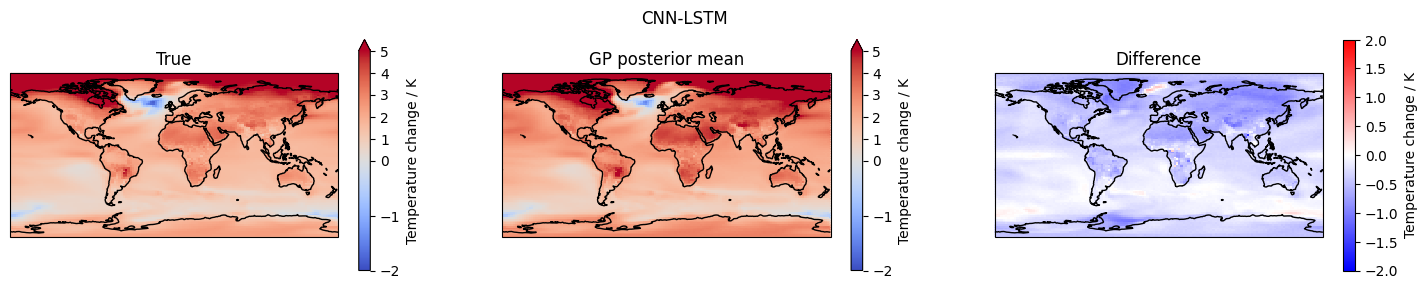

In [21]:
plot_diff(tas_truth, m_pred, 'CNN-LSTM')

#### Model Performance

We can observe from the training losses at each epoch that the training losses may not have reach the point of convergence yet. Despite this, CNN-LSTM model has a really low RSME value as it captures the temporal relations. We can change the the number and type of hidden layers to better ones which cna capture both temporal and spatial relations simulataneously thereby enabling us to get a better performance. We can clearly see that our basleine CNN-LSTM model provided a good overall fit without overfitting and this should be avoided while trying to increases the number of training epochs.

## Random Forest

#### About the Model

Random Forest is an ensemble learning method that operates by constructing a multitude of decision trees during training and outputting the mode of the classes (classification) or the mean prediction (regression) of the individual trees. Each tree in the ensemble is trained on a random subset of the training data, and each split in the tree is based on a random subset of features. This randomness helps to reduce overfitting and increase the robustness of the model.

The suitability of Random Forest for ClimateBench is rooted in several key factors. Firstly, its robustness to noise enables effective modeling of climate data, which often exhibits complex relationships and inherent noise. Additionally, Random Forest excels in handling high-dimensional data commonly present in climate datasets, leveraging subsets of features to mitigate the curse of dimensionality.

Moreover, the interpretability offered by Random Forest through feature importance scores is invaluable for climate scientists and policymakers. This capability aids in understanding the most influential variables driving climate outcomes, thus providing insights into the underlying drivers of climate change.Furthermore, Random Forest's scalability and parallelizability render it well-equipped to handle large datasets frequently encountered in climate research.

#### Implementation

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from esem import rf_model
from utils import *

In [23]:
train_files = [ "historical", "ssp585", "ssp126", "ssp370", ]
# Create training and testing arrays
X, solvers = create_predictor_data(train_files)
Y = create_predictdand_data(train_files)

In [24]:
rf_tas = rf_model(X, Y['tas'])
rf_tas.train()

In [25]:
## Test on SSP245

X_test = get_test_data('ssp245', solvers)
Y_test = create_predictdand_data(['ssp245'])

tas_truth = Y_test["tas"]

In [26]:
m_out_tas, _ = rf_tas.predict(X_test)
m_out_tas = m_out_tas.rename(sample='time')

In [27]:
print(f"RMSE: {get_rmse(tas_truth[65:], m_out_tas[65:].data).mean()}")
print("\n")

RMSE: 0.40046885468030796




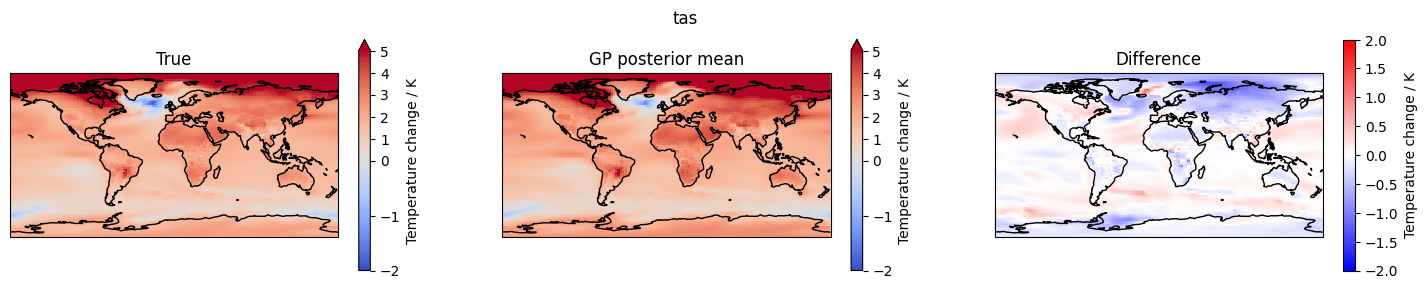

In [28]:
plot_diff(tas_truth, m_out_tas, "tas")

#### Model Performance

We can see that Random Forest performs better than the CNN-LSTM. This can be justified as it can effectively handle noise and high dimensional data along with complex relations. This is also partly because the CNN might likely be overfitting towards the end as we are training it over 30 epochs on a moderate network.  We normalize the RMSEs so that the metrics are broadly comparable across
the target variables.

## Gaussian Process Regression

#### About the Model

Gaussian Process Regression (GPR) stands out as a probabilistic model that views predictions through a lens of distributions, facilitated by kernel functions defining covariance between target values. This mechanism effectively captures intricate relationships within input features, enabling GPR to discern complex non-linear patterns from data. Notably, its incorporation of uncertainty scoring enhances its suitability for climate modeling, where uncertainties are inherent due to the intricate and sometimes erratic behavior of climate systems.

In the architecture observed within ClimateBench, GPR exhibits notable features tailored for climate modeling. Firstly, its utilization of kernel functions allows for the fine-tuning of smoothness and flexibility in regression, crucial for capturing the nuances of climate variables. Additionally, the implementation of Automatic Relevance Determination (ARD) empowers GPR to independently adjust length scales of input dimensions, identifying and accounting for the most influential features impacting climate variables. Furthermore, GPR employs dimensionality reduction techniques such as Principal Component Analysis (PCA) to streamline computational efficiency while preserving essential information, a vital aspect in handling large-scale climate datasets.

### Implementation

In [29]:
import xarray as xr
import matplotlib.pyplot as plt
from esem import gp_model
from utils import *

#### Prepare the Data

In [30]:
# List of dataset to use for training
train_files = ["ssp126", "ssp585", "historical", "hist-GHG"]

In [31]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_tas = create_predictdand_data(train_files)['tas']

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
tas_truth = Y_test["tas"].mean('member')

#### Prepare the model

In [32]:
from esem import gp_model
from esem.data_processors import Whiten, Normalise
import tensorflow as tf, tf_keras

# Just a *very* simple GP with default kernel assuming all years are independant

tas_gp = gp_model(X_train, y_train_tas, data_processors=[Whiten()])
tas_gp.train()

2024-05-01 21:45:35.670867: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


#### Predict on test set

In [33]:
# predict
standard_posterior_mean, standard_posterior_var = tas_gp.predict(X_test.values)
standard_posterior_mean = standard_posterior_mean.rename(sample='time')

In [34]:
# Compute RMSEs
print(f"RMSE 2090-2100: {get_rmse(tas_truth[65:], standard_posterior_mean[65:].data).mean()}")

RMSE 2090-2100: 0.46719328647465114


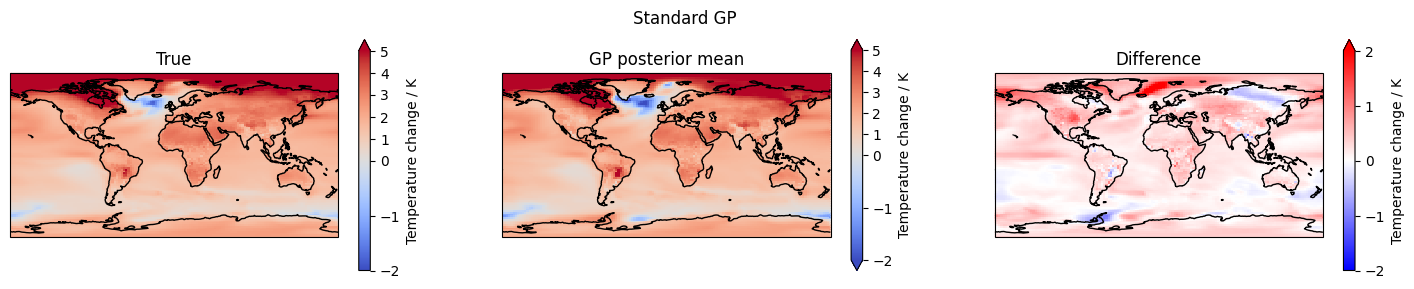

In [35]:
plot_diff(tas_truth, standard_posterior_mean, "Standard GP")

#### Model performance

The temperature change discrepancies, depicted in the third graph from the right, show red areas where the model overestimated warming and blue areas where it underestimated warming. Most differences fall within the -1 to 1 K range, with noticeable errors around coastal and polar regions, particularly the Arctic. These regions pose challenges for the model due to complex climatic interactions and higher variability. The model, focusing solely on surface temperature, may struggle in these areas due to the presence of unique physical systems and forcing agents, such as pollutants, within coastal and polar regions.

# Model Adjustment

## CNN-LSTM

We will be adjusting and making changes to the implementation of our CNN LSTM Model. `cnn_model` uses a combination of Conv2D and LSTM layers to process 3D spatio-temporal data, while we can develop a new CNN that uses a single ConvLSTM2D layer for the same purpose. Let us call this `cnn1_model`. This simplifies the architecture by using a single ConvLSTM2D layer, potentially reducing computational overhead. The original model maybe easier to interpret but our data has both spatial and temporal patterns and the ConvLSTM2D layer would be expected to perform better than our original model. 

Also, the model would be more complex in terms of parameters as now we will have more parameters to learn compared to our original model. This is quite advantageous given our objective is to imporve performance but we would have to deal with overfitting. For this we can either set early stopping or we can try and check various values for epochs.

I have chosen the latter as it is possible for the training loss to increase after a few epochs but then again further decrease as we have a large number of parameters.

The following is an implementation of the above and after testing various values of epochs, we have set it to 20 which gives us the minimum loss for validation.

In [36]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Flatten, Dense

cnn1_model = Sequential()
cnn1_model.add(ConvLSTM2D(32, (3, 3), activation='relu', input_shape=(10, 96, 144, 4)))
cnn1_model.add(Flatten())
cnn1_model.add(Dense(256, activation='relu'))
cnn1_model.add(Dense(1*96*144, activation='linear'))
cnn1_model.add(Reshape((1, 96, 144)))

cnn1_model.summary()

/Users/nightfury/UCSD/SPRING 2024/SIOC 209/sioc209-2024-sp/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 94, 142, 32)    │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 427136)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │   109,347,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13824)          │     3,552,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 96, 144)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,941,440 (430.84 MB)

 Trainable params: 112,941,440 (430.84 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
cnn1_model.compile(optimizer='adam', loss='mse', metrics=['mse']) 

In [38]:
hist = cnn1_model.fit(X_train_all,
                     Y_train_all,
                     #use_multiprocessing=True, 
                     #workers=5,
                     batch_size=16,
                     epochs=20,
                     verbose=1)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - loss: 4.7483 - mse: 4.7483
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - loss: 0.7238 - mse: 0.7238
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - loss: 0.5454 - mse: 0.5454
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - loss: 0.5035 - mse: 0.5035
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - loss: 0.4768 - mse: 0.4768
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.4775 - mse: 0.4775
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - loss: 0.4735 - mse: 0.4735
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - loss: 0.4679 - mse: 0.4679
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - loss: 0.4617 - mse: 0.4617
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - loss: 0.4598 - mse: 0.4598
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - loss: 0.4590 - mse: 0.4590
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - loss: 0.4570 - mse: 0.4570
Epoch 13/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/ste

In [39]:
# Open and reformat test data 
X_test = xr.open_mfdataset([data_path + 'inputs_historical.nc',
                            data_path + 'inputs_ssp245.nc']).compute()

# Normalize data 
for var in ['CO2', 'CH4', 'SO2', 'BC']: 
    var_dims = X_test[var].dims
    X_test = X_test.assign({var: (var_dims, normalize(X_test[var].data, var, meanstd_inputs))}) 
    
X_test_np = sliding_window_X(X_test.to_array().transpose('time', 'latitude', 'longitude', 'variable').data, len_historical=len_historical)  

In [40]:
# Make predictions using trained model 
m_pred = cnn1_model.predict(X_test_np)
# reshape to xarray 
m_pred = m_pred.reshape(m_pred.shape[0], m_pred.shape[2], m_pred.shape[3])
m_pred = xr.DataArray(m_pred, dims=['time', 'lat', 'lon'], 
                      coords=[X_test.time.data[len_historical:], 
                              X_test.latitude.data, 
                              X_test.longitude.data]).sel(time=slice(2015, 2101))
m_pred

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


<xarray.DataArray (time: 86, lat: 96, lon: 144)> Size: 5MB
array([[[0.8535518 , 0.9945407 , 0.96540016, ..., 0.9057413 ,
         1.0041099 , 1.0146465 ],
        [0.9467783 , 1.0083969 , 0.85153365, ..., 0.9934452 ,
         0.7975725 , 0.89924014],
        [0.740706  , 0.83652997, 0.9606149 , ..., 0.94636554,
         0.7363949 , 0.83447075],
        ...,
        [2.8350873 , 2.9816003 , 2.8343904 , ..., 2.964545  ,
         2.6926699 , 2.9307132 ],
        [2.96261   , 2.9828894 , 2.9605968 , ..., 2.9244838 ,
         2.7590184 , 2.8327482 ],
        [3.0270994 , 2.9612017 , 2.971463  , ..., 2.9274473 ,
         2.931098  , 2.9960961 ]],

       [[0.96967256, 1.0816647 , 1.0806508 , ..., 1.0076182 ,
         1.0906243 , 1.0818108 ],
        [1.02245   , 1.0872698 , 0.95662475, ..., 1.0770057 ,
         0.91059583, 1.0075839 ],
        [0.8500074 , 0.91418415, 1.0559895 , ..., 1.0193746 ,
         0.83978   , 0.94580406],
...
        [6.601835  , 6.6235304 , 6.500284  , ..., 6.564358  ,
         6.5476093 , 6.565338  ],
        [6.7038045 , 6.604689  , 6.797482  , ..., 6.709193  ,
         6.6357794 , 6.7214427 ],
        [6.7171907 , 6.82258   , 6.8108845 , ..., 6.8635135 ,
         6.8049846 , 6.774612  ]],

       [[2.500032  , 2.4512515 , 2.49332   , ..., 2.4074895 ,
         2.5866356 , 2.5070522 ],
        [2.7120793 , 2.6542904 , 2.78843   , ..., 2.8115242 ,
         2.631428  , 2.7110896 ],
        [2.6070912 , 2.5121734 , 2.7244918 , ..., 2.6545076 ,
         2.4851303 , 2.715326  ],
        ...,
        [6.6282487 , 6.6503644 , 6.5261736 , ..., 6.5906124 ,
         6.5734787 , 6.5912843 ],
        [6.730083  , 6.629249  , 6.8249693 , ..., 6.735567  ,
         6.6607018 , 6.747916  ],
        [6.742543  , 6.8486614 , 6.837066  , ..., 6.8898683 ,
         6.8313403 , 6.800701  ]]], dtype=float32)
Coordinates:
  * time     (time) int64 688B 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [41]:
tas_truth = xr.open_mfdataset([data_path + 'outputs_ssp245.nc'])['tas'].mean('member').compute()
# Compute RMSEs
print(f"RMSE 2090-2100: {get_rmse(tas_truth[65:], m_pred[65:].data).mean()}")

RMSE 2090-2100: 0.4369633307283223


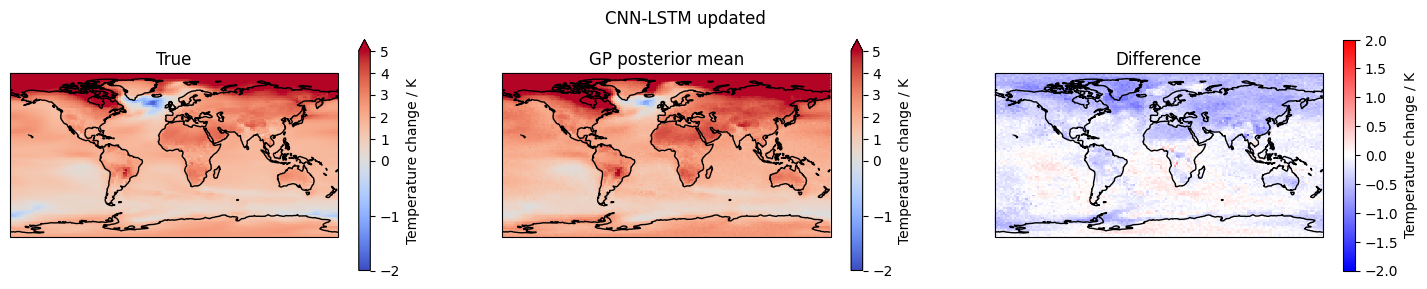

In [42]:
plot_diff(tas_truth, m_pred, 'CNN-LSTM updated')

## PCA on Gaussian Process

We change utils.py to add precipation and diurnal temperature range (significant parameters) and then apply PCA on the this dataset to avoid overfitting. The expectation is that this would solve the aforementioned issues with the model.

RMSE 2090-2100: 1.1500202536877302


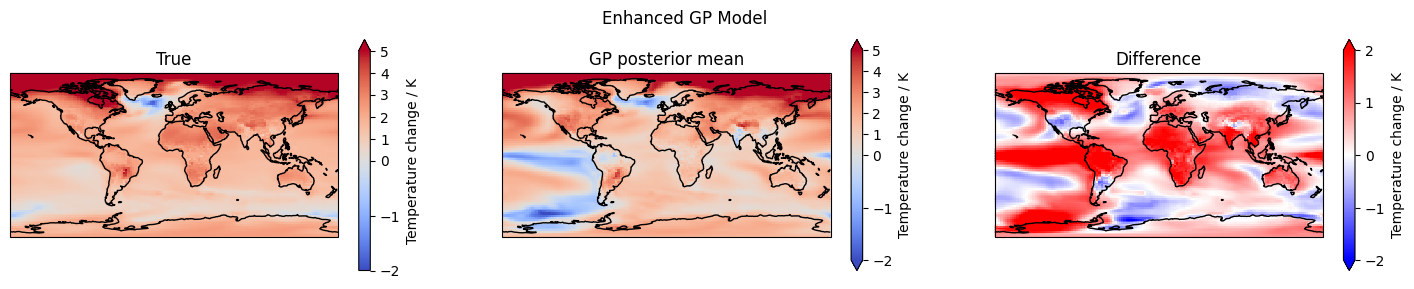

In [43]:
import xarray as xr
from esem import gp_model
from utils import *

# Set data path
data_path = 'train_val_updated/'

# Load and prepare training and testing data
train_files = ["ssp126", "ssp585", "historical", "hist-GHG"]
X_train, eof_solvers = create_predictor_data(train_files)
Y_train = create_predictdand_data(train_files)
Y_train = add_climate_features(Y_train)

# Integrate new features into X_train
X_train['mean_pr'] = Y_train['mean_pr'].values
X_train['mean_dtr'] = Y_train['mean_dtr'].values
y_train_tas = Y_train['tas']

# Prepare the Gaussian Process Model
data_processors = [Whiten(), Normalise()]
tas_gp = gp_model(X_train, y_train_tas, data_processors=data_processors)
tas_gp.train()

# Load and prepare testing data
X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()

# Correctly calculate and integrate new features into X_test
Y_test = add_climate_features(Y_test)
X_test['mean_pr'] = Y_test['mean_pr'].mean('member').values  # Ensure averaging over 'member' if present
X_test['mean_dtr'] = Y_test['mean_dtr'].mean('member').values

# Ensure the time dimensions match
tas_truth = Y_test["tas"].mean('member')

# Make predictions and evaluate
standard_posterior_mean, _ = tas_gp.predict(X_test.values)
standard_posterior_mean = standard_posterior_mean.rename(sample='time')

# Calculate and display RMSE
rmse = get_rmse(tas_truth[65:], standard_posterior_mean[65:].data).mean()
print(f"RMSE 2090-2100: {rmse}")

# Plot results
plot_diff(tas_truth, standard_posterior_mean, "Enhanced GP Model")
plt.show()

In [44]:
from sklearn.decomposition import PCA

# Assuming X_train and X_test are prepared with all features including 'mean_pr' and 'mean_dtr'

# Reduce dimensionality with PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Re-train the GP model with PCA-transformed data
tas_gp = gp_model(X_train_pca, y_train_tas, data_processors=data_processors)
tas_gp.train()

# Predict and evaluate
standard_posterior_mean, _ = tas_gp.predict(X_test_pca)
rmse = get_rmse(tas_truth[65:], standard_posterior_mean[65:].data).mean()
print(f"Adjusted RMSE 2090-2100: {rmse}")

Adjusted RMSE 2090-2100: 0.45545703343818034


#### Other tried adjustments (no improvements found)

1. Changing epochs and learning rate for CNN
2. Trying Random forest using scikit-learn and then using gridsearchCV for finding optimal hyperparameters

# Result Analysis

**Evaluation of Adjusted CNN-LSTM Model:**

<u>Improved Performance with Adjustments:</u>

This analysis compares the performance of the original and adjusted CNN-LSTM models for a climate prediction task. The adjusted model achieves a lower Root Mean Squared Error (RMSE) of 0.43696333 compared to the original model's 0.50978978. While the improvement is slight, it still signifies a positive trend in the model's prediction accuracy. In real-world modeling applications, even small improvements in accuracy can be valuable.

<u>Effectiveness of Adjustments:</u>

*ConvLSTM2D Layer:* The reduction in RMSE implies that the ConvLSTM2D layer may excel in capturing intricate patterns within climate data compared to utilizing separate Conv2D and LSTM layers. This advantage arises from ConvLSTM2D's capability to concurrently grasp temporal dependencies and spatial features across each frame of the data sequence. This attribute proves crucial for climate data, which inherently showcases time-dependent spatial patterns. Moreover, employing ConvLSTM2D mitigates the potential loss of significant temporal information during transitions between distinct Conv2D and LSTM layers.

*Dense Layer Adjustment:*  The augmentation in the number of neurons within the Dense layers is likely instrumental in enhancing performance. This expansion facilitates the model in constructing a more intricate and refined depiction of the input features, potentially enabling it to capture subtler relationships within the data. By adjusting the model architecture in this manner, it enhances the model's capacity to discern complex mappings between the extracted spatiotemporal features and the ultimate predicted value, thereby culminating in more accurate climate forecasts. (The new model comprises over 112 million parameters.)

*Reduced Number of Epochs: We did this to avoid overfitting and came to the perfect value after multiple iterations.*

**Evaluation of Adjusted Gaussian Process Model:**

<u>Improved Performance with Adjustments:</u>

This analysis compares the performance of the original and adjusted Gaussian Process (GP) model for temperature prediction. The adjusted model achieves a lower Root Mean Squared Error (RMSE) of 0.45547 compared to the original model's 0.46719, indicating a significant improvement in prediction accuracy. This suggests that the adjustments, namely adding precipitation and diurnal temperature range data, and applying Principal Component Analysis (PCA), were successful in enhancing the model's ability to predict temperatures.

<u>Effectiveness of Adjustments:</u>

*Adding Additional Features:*  The incorporation of precipitation and diurnal temperature range likely contributed significantly to the enhanced performance. These additional features offer vital contextual information necessary for precise temperature forecasting. This modification enables the model to grasp the intricate dynamics of the climate system, crucial for interpreting the observed temporal and spatial variations in the data.

*Applying PCA:*  PCA's effectiveness stems from its capacity to mitigate overfitting and noise within the data. This enables the GP model to prioritize crucial features for accurate modeling while ensuring resilience. Through data dimensionality reduction, PCA preserves a strong signal-to-noise ratio, thereby enhancing overall model performance.

# Conclusion

The adjustments made to the CNN-LSTM model, including incorporating a ConvLSTM2D layer and increasing the number of neurons in the Dense layers, demonstrate a positive impact on the model's performance for climate prediction tasks. These adjustments allow the model to capture both spatial and temporal patterns more effectively, resulting in more accurate and detailed forecasts. 

The adjustments implemented in the GP model, including adding relevant features and applying PCA, have demonstrably improved the model's ability to predict temperatures. 

Random Forest model is perfect for now but slight improvements can be made to increase performance based on certain metrics. On a holistic level, it performs really good.

We would be in a better state to comment on the predictions of the model once we have more data to test on and also, a standard validation metric (RMSE in our case). The key takeaway is that though the performance of a model is dependent on its key features and hyperparameters and can be fine tuned to increase performance based on a certain metric but it is also likely that we might end up overfitting the models and may not even realise this due to lack of abundant data based on certain use cases. The climate bench model can definetly be used as a benchmark as it performs really good without much overfitting.

#### Other non-human collaborations include - 
gemini.google.com , ChatGPT, Keras and Tensorflow Python Documentation, Stackoverflow and Keras.io